In [1]:
import csv
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split

# get the data 
wine_data = pd.read_csv("wine-white-red-labels.csv", ";")
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 fixed  acidity           6497 non-null float64
volatile  acidity         6497 non-null float64
citric  acid              6497 non-null float64
residual  sugar           6497 non-null float64
chlorides                 6497 non-null float64
free  sulfur  dioxide     6497 non-null float64
total  sulfur  dioxide    6497 non-null float64
density                   6497 non-null float64
pH                        6497 non-null float64
sulphates                 6497 non-null float64
alcohol                   6497 non-null float64
quality                   6497 non-null int64
label                     6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 659.9 KB


In [2]:
# split the data randomly 
train_set, test_set  = train_test_split(wine_data, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

# wine_data is now the training set
wine_data = train_set

5197 train + 1300 test


In [4]:
# seems like there is a slight correlation between quality and alcohol
# the closer to 1 the better

# lets look at some correlations
corr_matrix = wine_data.corr()
corr_matrix["alcohol"].sort_values(ascending=False)

alcohol                   1.000000
quality                   0.448437
pH                        0.115036
label                     0.026128
sulphates                 0.000044
citric  acid             -0.010303
volatile  acidity        -0.038758
 fixed  acidity          -0.087069
free  sulfur  dioxide    -0.183278
chlorides                -0.250200
total  sulfur  dioxide   -0.273108
residual  sugar          -0.365590
density                  -0.683560
Name: alcohol, dtype: float64

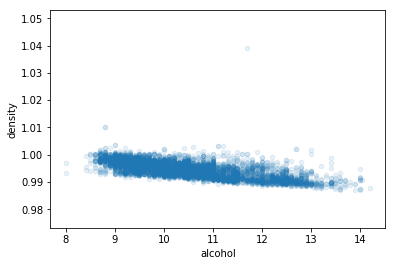

In [5]:
wine_data.plot(kind="scatter", x="alcohol", y="density", alpha=0.1)

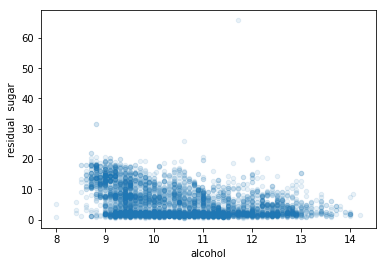

In [6]:
wine_data.plot(kind="scatter", x="alcohol", y="residual  sugar", alpha=0.1)

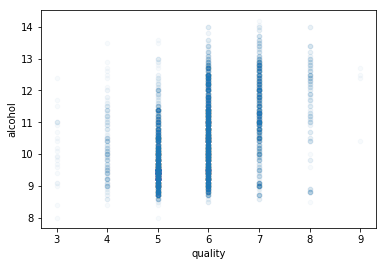

In [7]:
wine_data.plot(kind="scatter", x="quality", y="alcohol", alpha=0.03)

In [10]:
def wine_quality_prop(data):
    return data["quality"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall": wine_quality_prop(wine_data),
    "Random": wine_quality_prop(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props

# drop labels for training set
wine_data = train_set.drop("quality", axis=1) 
wine_data_labels = train_set["quality"].copy()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np 

lin_reg = LinearRegression()
lin_reg.fit(wine_data, wine_data_labels)
wine_predictions = lin_reg.predict(wine_data)
lin_mse = mean_squared_error(wine_data_labels, wine_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

/Users/georgemdonnelly/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.73184149298430357

In [12]:
# this seems promising but did it overfit?
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(wine_data, wine_data_labels)
wine_tree_predictions = tree_reg.predict(wine_data)
tree_mse = mean_squared_error(wine_data_labels, wine_tree_predictions)
tree_rsme = np.sqrt(tree_mse)
tree_rsme

0.0

In [13]:
# looks like the decision tree did better but this one has a small error
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(wine_data, wine_data_labels)
wine_random_predictions = forest_reg.predict(wine_data)
forest_mse = mean_squared_error(wine_data_labels, wine_random_predictions)
forest_rsme = np.sqrt(forest_mse)
forest_rsme

0.26989618083957312

0.0

In [160]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [1,2,3,4]},
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4, 6]},
  ]

forest_reg = RandomForestRegressor(random_state=12)
# train across 5 folds, that's a total of (12)*5 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(wine_data, wine_data_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=12, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [161]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.736729530919 {'max_features': 1, 'n_estimators': 3}
0.652118703271 {'max_features': 1, 'n_estimators': 10}
0.622728184598 {'max_features': 1, 'n_estimators': 30}
0.730170847523 {'max_features': 2, 'n_estimators': 3}
0.646230615246 {'max_features': 2, 'n_estimators': 10}
0.620399343653 {'max_features': 2, 'n_estimators': 30}
0.72744265298 {'max_features': 3, 'n_estimators': 3}
0.64079455681 {'max_features': 3, 'n_estimators': 10}
0.620926896334 {'max_features': 3, 'n_estimators': 30}
0.719255429737 {'max_features': 4, 'n_estimators': 3}
0.642300200697 {'max_features': 4, 'n_estimators': 10}
0.62273659602 {'max_features': 4, 'n_estimators': 30}


In [8]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("quality", axis=1)
y_test = test_set["quality"].copy()

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

NameError: name 'grid_search' is not defined

In [14]:
test = test_set.drop("quality", axis=1)
test_labels = test_set["quality"].copy()

final_model = RandomForestRegressor()
final_model.fit(test, test_labels)
wine_random_predictions = final_model.predict(test)
forest_mse = mean_squared_error(test_labels, wine_random_predictions)
forest_rsme = np.sqrt(forest_mse)
forest_rsme

0.31237305113745495

In [15]:
range_x = []
range_y = []
for i in range(0,1300):
    range_x.append(test_set.iloc[i][11])
    range_y.append(round(wine_random_predictions[i],0))

In [58]:
data = pd.DataFrame ({
'Machine' : range_y,
'Human' : range_x,
})

Text(6,-105,'Quality')

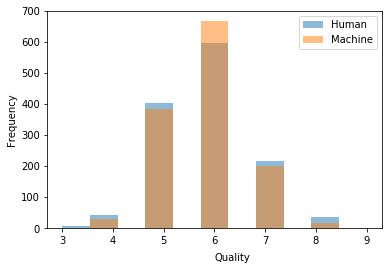

In [56]:
#data.plot(kind="scatter", x="Human", y="Machine")
fig = data.plot.hist(alpha=0.5, bins=11)

fig.text(6.0, -105.00, 'Quality')

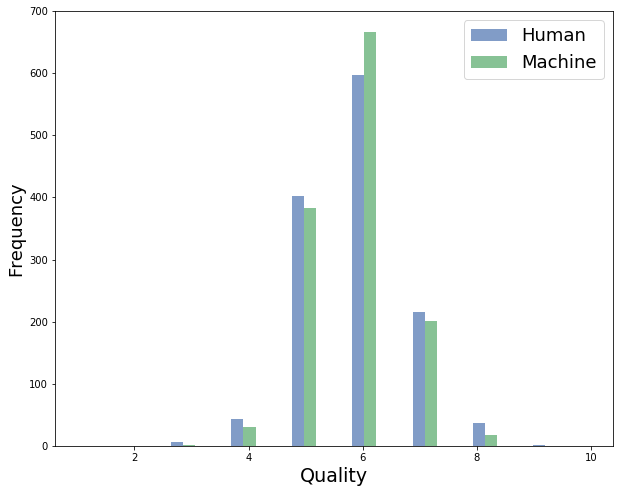

In [143]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-deep')

data = np.vstack([range_x, range_y]).T
bins = np.linspace(1, 10, 18)

plt.rcParams["figure.figsize"] = (10,8)
plt.hist(data, bins, alpha=0.7, label=['Human', 'Machine'])
plt.legend(loc='upper right', fontsize=18)
plt.xlabel('Quality', fontsize=19)
plt.ylabel('Frequency', fontsize=18)
plt.show()

0    6.0
dtype: float64

In [87]:
data

,Human,Machine
0,8.0,6.9
1,5.0,5.0
2,7.0,6.9
3,6.0,5.8
4,6.0,5.7
5,6.0,6.0
6,5.0,5.4
7,6.0,6.4
8,5.0,5.1
9,7.0,6.6
